# Introduction to Convolutional Neural Networks and Computer Vision with

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self-driving car recognizing the car in front.

Video N°107: Downloading an image dataset for our first Food Vision model

## Get the data

The images we're working with are from the Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modified it to only use two classes (pizza 🍕 & steak 🥩) using the image data modification notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> 🔑 **Note:** We start with a smaller dataset so we can experiment quickly and figure what works (or better yet what doesn't work) before scaling up.

In [86]:
import pandas as pd
from utils.data_acquisition.data_downloader import download_data
url = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"
download_data(url=url, filename="pizza_steak", extract=True)

The file pizza_steak already exists.


Video N°108: Becoming One With Data

## Inspect the data (become one with it)

A very crucial step at the beginning of any machine learning project is becoming one with the data.
And for a computer vision project... this usually means visualizing many samples of your data.

In [3]:
!ls pizza_steak

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
test  train


In [4]:
!ls pizza_steak/train/

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
pizza  steak


In [5]:
!ls pizza_steak/train/steak

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775

In [6]:
import os
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk('pizza_steak'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 0 images in pizza_steak.
There are 2 directories and 0 images in pizza_steak/train.
There are 0 directories and 750 images in pizza_steak/train/steak.
There are 0 directories and 750 images in pizza_steak/train/pizza.
There are 2 directories and 0 images in pizza_steak/test.
There are 0 directories and 250 images in pizza_steak/test/steak.
There are 0 directories and 250 images in pizza_steak/test/pizza.


In [7]:
!ls -al pizza_steak

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
total 16
drwxr-xr-x 4 wm18vw wm18vw 4096 Mar 16 21:16 .
drwxr-xr-x 3 wm18vw wm18vw 4096 Mar 16 21:18 ..
drwxr-xr-x 4 wm18vw wm18vw 4096 Mar 16 21:16 test
drwxr-xr-x 4 wm18vw wm18vw 4096 Mar 16 21:16 train


Video N°109: Becoming One With Data Part 2

In [8]:
# Another way to find out how many images are in a directory
num_steak_images_train = len(os.listdir('pizza_steak/train/steak'))
num_steak_images_train

750

To visualize our images, first let's get the class names programmatically.

In [9]:
# Get the class names programmatically
import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['pizza' 'steak']


In [10]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_images(target_dir, target_class):
    # Setup the target directory (we'll view images from here)
    target_folder = os.path.join(target_dir, target_class)
    
    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    print(random_image)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(os.path.join(target_folder, random_image[0]))
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image shape: {img.shape}") # show the shape of the image
    
    return img

['317206.jpg']
Image shape: (382, 512, 3)


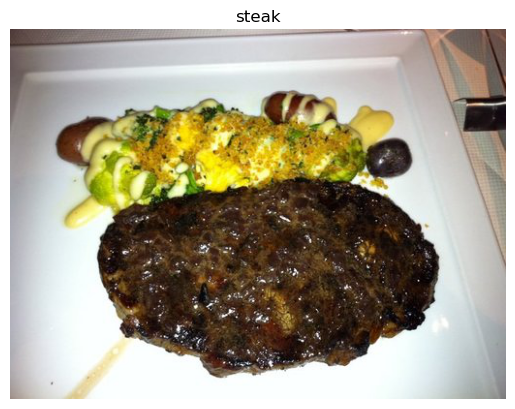

In [11]:
# View a random image from the training dataset
img = view_random_images(target_dir="pizza_steak/train/",
                         target_class="steak")

In [12]:
# The images we've imported and plotted are actually giant arrays/tensors of different pixel values
import tensorflow as tf
tf.constant(img)

2024-03-17 19:37:04.184191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-17 19:37:06.884585: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-17 19:37:07.043819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-17 19:37:07.044005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there m

<tf.Tensor: shape=(382, 512, 3), dtype=uint8, numpy=
array([[[ 82,  62,  61],
        [ 76,  56,  55],
        [ 74,  54,  53],
        ...,
        [ 95,  70,  63],
        [ 94,  69,  64],
        [ 97,  72,  67]],

       [[ 79,  59,  58],
        [ 78,  58,  57],
        [ 78,  58,  57],
        ...,
        [100,  73,  66],
        [ 99,  74,  69],
        [101,  76,  71]],

       [[ 75,  55,  54],
        [ 80,  60,  59],
        [ 82,  62,  61],
        ...,
        [104,  75,  67],
        [103,  76,  69],
        [102,  75,  68]],

       ...,

       [[158, 143, 138],
        [160, 145, 140],
        [163, 148, 143],
        ...,
        [127, 127, 127],
        [126, 126, 126],
        [125, 125, 125]],

       [[156, 141, 134],
        [158, 143, 136],
        [161, 146, 139],
        ...,
        [126, 126, 126],
        [125, 125, 125],
        [124, 124, 124]],

       [[154, 139, 132],
        [156, 141, 134],
        [159, 144, 137],
        ...,
        [125, 125, 12

Video N°110: Becoming One With Data Part 3

In [13]:
# View the image shape
img.shape # returns width, height, colour channels

(382, 512, 3)

🔑 **Note:** As we've discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255. (since 255 is the maximum pixel value).

In [14]:
img.min(), img.max()

(0, 255)

In [15]:
# Get all the pixel values between 0 & 1 (scale/normalize the data, as neural networks love values between 0 & 1)
img/255

array([[[0.32156863, 0.24313725, 0.23921569],
        [0.29803922, 0.21960784, 0.21568627],
        [0.29019608, 0.21176471, 0.20784314],
        ...,
        [0.37254902, 0.2745098 , 0.24705882],
        [0.36862745, 0.27058824, 0.25098039],
        [0.38039216, 0.28235294, 0.2627451 ]],

       [[0.30980392, 0.23137255, 0.22745098],
        [0.30588235, 0.22745098, 0.22352941],
        [0.30588235, 0.22745098, 0.22352941],
        ...,
        [0.39215686, 0.28627451, 0.25882353],
        [0.38823529, 0.29019608, 0.27058824],
        [0.39607843, 0.29803922, 0.27843137]],

       [[0.29411765, 0.21568627, 0.21176471],
        [0.31372549, 0.23529412, 0.23137255],
        [0.32156863, 0.24313725, 0.23921569],
        ...,
        [0.40784314, 0.29411765, 0.2627451 ],
        [0.40392157, 0.29803922, 0.27058824],
        [0.4       , 0.29411765, 0.26666667]],

       ...,

       [[0.61960784, 0.56078431, 0.54117647],
        [0.62745098, 0.56862745, 0.54901961],
        [0.63921569, 0

Video N°111: Building an end to end CNN Model

## An end-to-end example

Let's build a convolutional neural network to find patterns in our images, more specifically we a need way to:
* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 & 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
train_dir = pathlib.Path("pizza_steak/train")
test_dir = pathlib.Path("pizza_steak/test")

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(directory=train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(directory=test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation=tf.keras.activations.relu,
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=2,
                                 padding="valid"),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation=tf.keras.activations.relu),
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation=tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# Compile our CNN
model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.BinaryAccuracy())

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5


2024-03-17 19:37:08.546583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-03-17 19:37:08.736584: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-17 19:37:09.183891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-17 19:37:09.189534: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f08fcd608d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-17 19:37:09.189560: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-03-17 19:37:09.211267: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-17 19:37:09.34163

47/47 [==============================] - 15s 227ms/step - loss: 0.5567 - binary_accuracy: 0.7007 - val_loss: 0.4424 - val_binary_accuracy: 0.8000
Epoch 2/5
47/47 [==============================] - 7s 155ms/step - loss: 0.4474 - binary_accuracy: 0.7940 - val_loss: 0.3742 - val_binary_accuracy: 0.8520
Epoch 3/5
47/47 [==============================] - 7s 142ms/step - loss: 0.4087 - binary_accuracy: 0.8253 - val_loss: 0.3448 - val_binary_accuracy: 0.8380
Epoch 4/5
47/47 [==============================] - 7s 147ms/step - loss: 0.3617 - binary_accuracy: 0.8413 - val_loss: 0.3199 - val_binary_accuracy: 0.8840
Epoch 5/5
47/47 [==============================] - 7s 158ms/step - loss: 0.3058 - binary_accuracy: 0.8753 - val_loss: 0.2896 - val_binary_accuracy: 0.8820


Video N°112: Using a GPU to run our CNN model 5x faster

> 🔑 **Note:** If the above cell is taking longer than ~10 seconds per epoch, make sure you're using a GPU.

In [17]:
# Get a model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

🛠 **Practice/exercise:** Go through the CNN explainer website for a minimum of 10 minutes and compare our neural network with theirs: https://poloclub.github.io/cnn-explainer/

Video N°113: Trying a non-CNN model on our image data

## Using the same model as before

Let's replicate the model we've built in a previous section to see if it works with our image data.

The model we're building is from the [TensorFlow playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.32373&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [18]:
train_data

In [19]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# Compile the model
model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.BinaryAccuracy())

# Fir the model
model_2.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 8s 160ms/step - loss: 0.7383 - binary_accuracy: 0.5007 - val_loss: 0.6932 - val_binary_accuracy: 0.5120
Epoch 2/5
47/47 [==============================] - 7s 143ms/step - loss: 0.6935 - binary_accuracy: 0.4987 - val_loss: 0.6931 - val_binary_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 8s 163ms/step - loss: 0.6934 - binary_accuracy: 0.4880 - val_loss: 0.6932 - val_binary_accuracy: 0.5020
Epoch 4/5
47/47 [==============================] - 8s 174ms/step - loss: 0.6934 - binary_accuracy: 0.4867 - val_loss: 0.6931 - val_binary_accuracy: 0.4800
Epoch 5/5
47/47 [==============================] - 7s 152ms/step - loss: 0.6933 - binary_accuracy: 0.5013 - val_loss: 0.6932 - val_binary_accuracy: 0.5060


Video N°114: Improving our non-CNN model by adding more layers

In [20]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


Despite having 20x more parameters than our CNN (model_1), model_2 performs terribly... let's try to improve it.

In [21]:
# Set the random seed
tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(100, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

# Compile the model
model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.BinaryCrossentropy())

# Fit the model
history_3 = model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 9s 160ms/step - loss: 4.1335 - binary_crossentropy: 4.1335 - val_loss: 0.9309 - val_binary_crossentropy: 0.9309
Epoch 2/5
47/47 [==============================] - 7s 159ms/step - loss: 1.0349 - binary_crossentropy: 1.0349 - val_loss: 0.4677 - val_binary_crossentropy: 0.4677
Epoch 3/5
47/47 [==============================] - 7s 140ms/step - loss: 0.6930 - binary_crossentropy: 0.6930 - val_loss: 0.4377 - val_binary_crossentropy: 0.4377
Epoch 4/5
47/47 [==============================] - 7s 143ms/step - loss: 0.5620 - binary_crossentropy: 0.5620 - val_loss: 0.7426 - val_binary_crossentropy: 0.7426
Epoch 5/5
47/47 [==============================] - 7s 151ms/step - loss: 0.5694 - binary_crossentropy: 0.5694 - val_loss: 0.9850 - val_binary_crossentropy: 0.9850


In [22]:
# Get a summary of model_3
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 100)               15052900  
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


In [23]:
15073201/31101

484.6532587376612

Video N°115: Breaking our CNN model down part 1: Becoming one with the data

🔑 **Note:** You can think of trainable parameters as patterns a model can learn from data. Intuitively, you might think more is better. And in lots of cases, it is. But in this case, the difference here is the two different styles of model we're using. Where a series of dense layers has a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**.
So even though these are less learnable parameters in our convolutional neural network, these are often more helpful in deciphering between different **features** in an image.

In [24]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

## Binary Classification: Let's break it down

1. Become one with the data (visualize, visualize, visualize)
2. Preprocess the data (prepared it for our model, the main step here was scaling/normalizing)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve the model (try to beat our basline)
7. Repeat until satisfied (experiment, experiment, experiment)

### 1. Become one with the data

['3538682.jpg']
Image shape: (384, 512, 3)
['898303.jpg']
Image shape: (512, 512, 3)


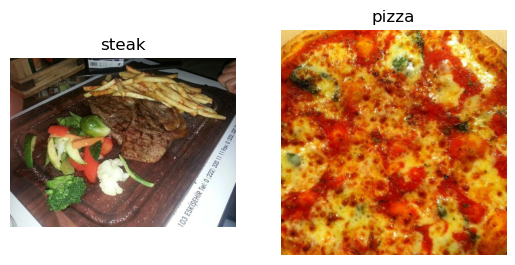

In [25]:
# Visualize data
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_images("pizza_steak/train/", "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_images("pizza_steak/train/", "pizza")

Video N°116: Breaking our CNN model down part 2: Preparing to load our data

### 2. Preprocess the data (prepare it for a model)

In [26]:
# Define directory dataset paths
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

Our next step is to turn our data into **batches**.

A batch is a small subset of data. Rather than look at all ~10000 images at one time, a model might only look at 32 at a time.

It does this for a couple of reasons:
1. 10000 images (or more) might not fit into the memory of your processor (GPU).
2. Trying to learn the patterns in 10000 images in one hit could result in the model not being able to learn very well.

Why 32? &rarr; https://arxiv.org/pdf/1804.07612.pdf


In [27]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

Video N°117: Breaking our CNN model down part 3: Loading our data with ImageDataGenerator

In [28]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, # target directory of images
                                               target_size=(224, 224), # target size of images (height, width)
                                               class_mode='binary', # type of data you're working with
                                               batch_size=32) # size of minibatches to load data into
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                               target_size=(224, 224),
                                               class_mode='binary',
                                               batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [29]:
# Get a sample of a train data batch
images, labels = train_data.next() # get the "next" batch of images/labels in train_data
len(images), len(labels)

(32, 32)

In [30]:
# How many batches are there?
len(train_data)

47

In [31]:
# We have 1500 images divided into 47 batches of 32 images
1500/32

46.875

In [32]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.47058827, 0.40784317, 0.34509805],
          [0.4784314 , 0.427451  , 0.3647059 ],
          [0.48627454, 0.43529415, 0.37254903],
          ...,
          [0.8313726 , 0.70980394, 0.48627454],
          [0.8431373 , 0.73333335, 0.5372549 ],
          [0.87843144, 0.7725491 , 0.5882353 ]],
 
         [[0.50980395, 0.427451  , 0.36078432],
          [0.5058824 , 0.42352945, 0.35686275],
          [0.5137255 , 0.4431373 , 0.3647059 ],
          ...,
          [0.82745105, 0.7058824 , 0.48235297],
          [0.82745105, 0.70980394, 0.5058824 ],
          [0.8431373 , 0.73333335, 0.5372549 ]],
 
         [[0.5254902 , 0.427451  , 0.34901962],
          [0.5372549 , 0.43921572, 0.36078432],
          [0.5372549 , 0.45098042, 0.36078432],
          ...,
          [0.82745105, 0.7019608 , 0.4784314 ],
          [0.82745105, 0.7058824 , 0.49411768],
          [0.8352942 , 0.7176471 , 0.5137255 ]],
 
         ...,
 
         [[0.77647066, 0.5647059 , 0.2901961 ],
          [0.78039

In [33]:
# images have been resized
images[7].shape, images[11].shape, images[16].shape, images[21].shape

((224, 224, 3), (224, 224, 3), (224, 224, 3), (224, 224, 3))

In [34]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1.],
      dtype=float32)

Video N°118: Breaking our CNN model down part 4: Building a baseline CNN model

### 3. Create a CNN model (start with a baseline)

A basline is a relatively simple model or existing result that you setup when beginning a machine learning experiment and then as you keep experimenting, you try to beat the baseline.

> 🔑 **Note:** In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem).

In [35]:
# Make the creating of our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [36]:
# Create the model (this will be our baseline, a layer convolutional neural network)
model_4 = Sequential([
    Conv2D(filters=10, # filter is the number of sliding windows going across an input (higher = more complex model)
           kernel_size=3, # or (3, 3) the size of the sliding window going across an input
           strides=1, # or (1, 1) the size of the step the sliding window takes across an input
           padding="valid", # if "same", output shape is same as input shape, if "valid", output shape gets compressed
           activation="relu",
           input_shape=(224, 224, 3)), # input layer (specify input shape)
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid") # output layer (working with binary classification so only 1 output neuron)
])

Video N°119: Breaking our CNN model down part 5: Looking inside a Conv2D layer

🛠 **Practice:** Understand what's going on in a Conv2D layer by going through the CNN explainer website for 10-20 minutes: [https://poloclub.github.io/cnn-explainer/
](https://poloclub.github.io/cnn-explainer/)

Video N°120: Breaking our CNN model down part 6: Compiling and fitting our baseline CNN

In [37]:
# Complie the model
model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=tf.keras.metrics.BinaryAccuracy())

In [38]:
# Get a summary of our model
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477,341
Trainable params: 477,341
Non-trainable params: 0
_________________________________________________________________


`conv2d_4 (Conv2D)           (None, 222, 222, 10)      280`:
Nous avons 222, 222 car nous avons padding="valid" et que input_shape est en 224, 244 ce qui fait que nous perdons les bords.


### 4. Fit the model

In [39]:
# Check the lengths of training and test data generators
len(train_data), len(test_data)

(47, 16)

In [40]:
# Fit the model
history_4 = model_4.fit(train_data, # this is a combination of labels and sample data
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 176ms/step - loss: 0.7354 - binary_accuracy: 0.6827 - val_loss: 0.4605 - val_binary_accuracy: 0.7780
Epoch 2/5
47/47 [==============================] - 7s 138ms/step - loss: 0.4587 - binary_accuracy: 0.7987 - val_loss: 0.4161 - val_binary_accuracy: 0.8240
Epoch 3/5
47/47 [==============================] - 7s 154ms/step - loss: 0.3367 - binary_accuracy: 0.8647 - val_loss: 0.3943 - val_binary_accuracy: 0.8240
Epoch 4/5
47/47 [==============================] - 8s 161ms/step - loss: 0.1764 - binary_accuracy: 0.9407 - val_loss: 0.4894 - val_binary_accuracy: 0.7940
Epoch 5/5
47/47 [==============================] - 7s 152ms/step - loss: 0.0649 - binary_accuracy: 0.9813 - val_loss: 0.8841 - val_binary_accuracy: 0.7460


Video N°121: Breaking our CNN model down part 7: Evaluating our CNN's training curves

### 5. Evaluating our model

It looks like our model is learning something, let's evaluate it.

<Axes: >

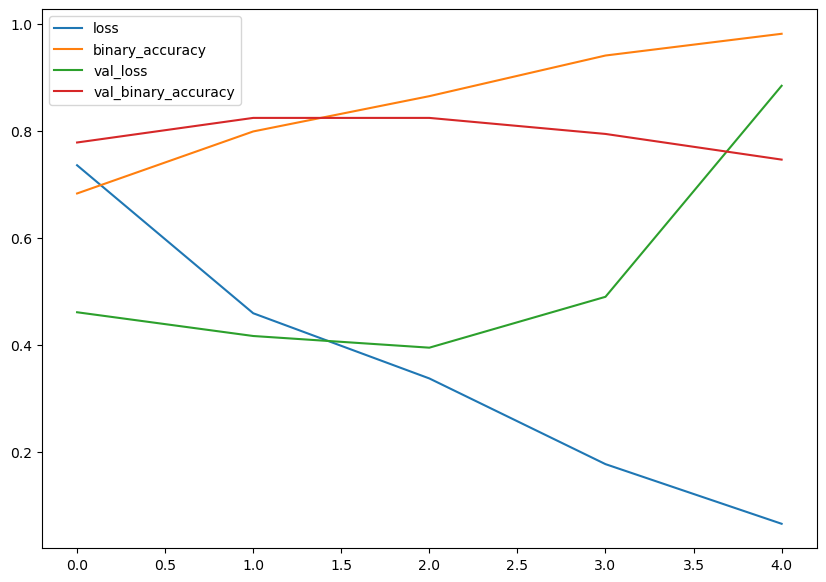

In [41]:
# Let's plot the training curves
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

In [87]:
# Plot the validation and training curves separatly
from utils.data_visualization.model_learning_curves import plot_loss_curves

🔑 **Note:** When a model's **validation loss starts to increase**, it's likely that the model is **overfitting** the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus the model's ability to generalize to unseen data will be diminished.

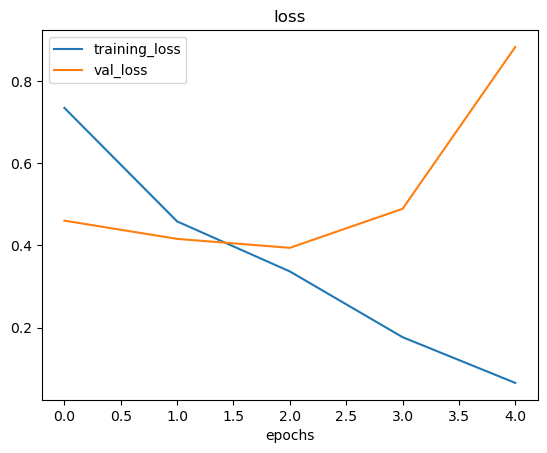

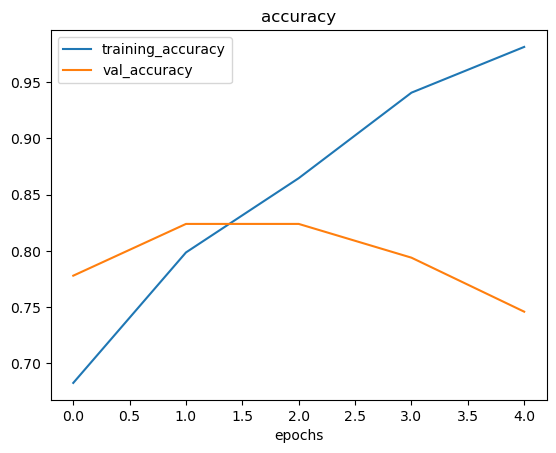

In [88]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

🔑 **Note:** Ideally the two loss curves (training and validation) will be very similar to each other decreasing at similar rates), when there are large differences your model may be **overfitting**.

Video N° 122: Breaking our CNN model down part 8: Reducing overfitting with Max Pooling

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:
0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> 🔑 **Note:** Reducing overfitting is also known as **regularization**.

In [44]:
# Create the model (this is going to be our new baseline)
model_5 = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

**About `pool_size`:** - Video N°122 @ 6:16<br>
Downsample the input representation by taking the max value over the window defined by `pool_size` for each dimension along the features axis.

In [45]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [46]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 10s 170ms/step - loss: 0.6850 - accuracy: 0.5693 - val_loss: 0.6066 - val_accuracy: 0.7740
Epoch 2/5
47/47 [==============================] - 7s 159ms/step - loss: 0.5213 - accuracy: 0.7627 - val_loss: 0.4069 - val_accuracy: 0.8400
Epoch 3/5
47/47 [==============================] - 8s 165ms/step - loss: 0.4520 - accuracy: 0.7913 - val_loss: 0.3529 - val_accuracy: 0.8380
Epoch 4/5
47/47 [==============================] - 7s 158ms/step - loss: 0.4240 - accuracy: 0.8100 - val_loss: 0.3608 - val_accuracy: 0.8680
Epoch 5/5
47/47 [==============================] - 8s 167ms/step - loss: 0.4089 - accuracy: 0.8193 - val_loss: 0.3765 - val_accuracy: 0.8480


In [47]:
# Get a summary of our model with max pooling
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 10)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 10)      

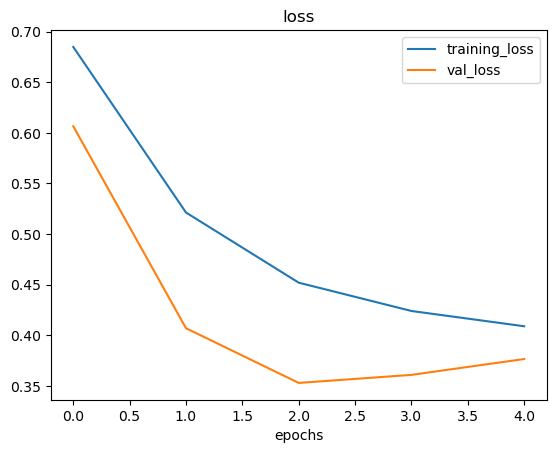

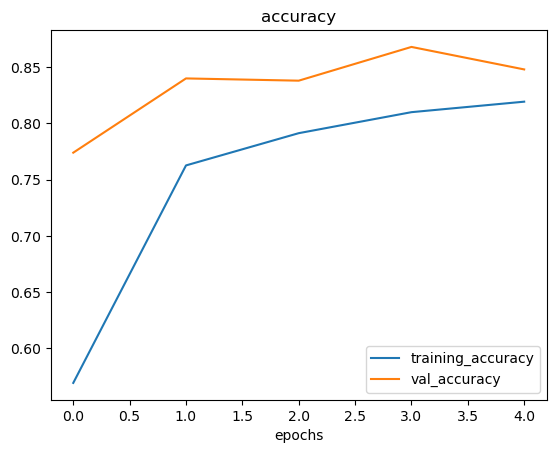

In [89]:
# Plot loss curves
plot_loss_curves(history_5)

Video N°123: Breaking our CNN model down part 9: Reducing overfitting with data augmentation

### Opening our bag of tricks and finding data augmentation

In [65]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255,
                                             rotation_range=0.2, # how much do you want to rotate an image?
                                             shear_range=0.2, # how much do you want to shear an image?
                                             zoom_range=0.2, # zoom in randomly on an image
                                             width_shift_range=0.2, # move your image around on the x-axis
                                             height_shift_range=0.3, # move your image around on the y-axis
                                             horizontal_flip=True) # do you want to flip an image?

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255)

> 🤔 **Question:** What is data augmentation?

Data augmentation is the process of altering  our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns.
Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Let's write some code to visualize data augmentation...

Video N°124: Breaking our CNN model down part 10: Visualizing our augmentation

In [66]:
common_args = {
    "target_size": (224, 224),
    "batch_size": 32,
    "class_mode": "binary",
    "shuffle": False  # for demonstration purpose only
}

In [67]:
# import data and augment it from training directory
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, **common_args)

# Create non-augmented train data batches
print("Non-augmented training data:")
train_data = train_datagen.flow_from_directory(train_dir, **common_args)

# Create non-augmented test data batches
print("Non-augmented test data:")
test_data = test_datagen.flow_from_directory(test_dir, **common_args)

Augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented test data:
Found 500 images belonging to 2 classes.


🔑 **Note:** Data augmentation is usually only performed on the training data. Using `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are modified as they're loaded into the model.

Finally... let's visualize some augmented data!!!

In [68]:
# Get sample data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # note: labels aren't augments... only data (images)

In [90]:
# Show original image and augmented image
from utils.data_visualization.augmentation_effects import plot_original_and_augmented

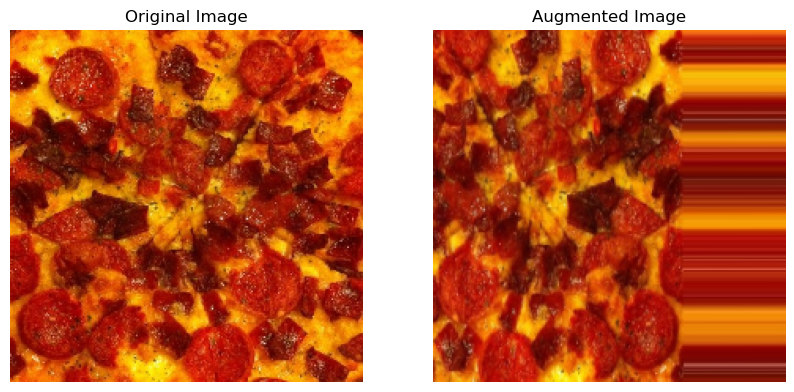

In [91]:
plot_original_and_augmented(original_images=images, augmented_images=augmented_images)

Video N°125: Breaking our CNN model down part 11: Training a CNN model on augmented data

Now we've seen what augmente training data looks like, let's build a model and see how it learns on augmented data.

In [71]:
# Create a model (same as model_5)
model_6 = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_6 = model_6.fit(train_data_augmented, # fitting model_6 on augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 17s 341ms/step - loss: 0.7013 - accuracy: 0.4860 - val_loss: 0.6899 - val_accuracy: 0.5680
Epoch 2/5
47/47 [==============================] - 16s 348ms/step - loss: 0.6960 - accuracy: 0.5307 - val_loss: 0.6890 - val_accuracy: 0.6380
Epoch 3/5
47/47 [==============================] - 16s 343ms/step - loss: 0.6957 - accuracy: 0.5187 - val_loss: 0.6875 - val_accuracy: 0.6140
Epoch 4/5
47/47 [==============================] - 16s 344ms/step - loss: 0.6911 - accuracy: 0.5547 - val_loss: 0.6719 - val_accuracy: 0.5260
Epoch 5/5
47/47 [==============================] - 17s 358ms/step - loss: 0.7036 - accuracy: 0.5667 - val_loss: 0.6597 - val_accuracy: 0.6120


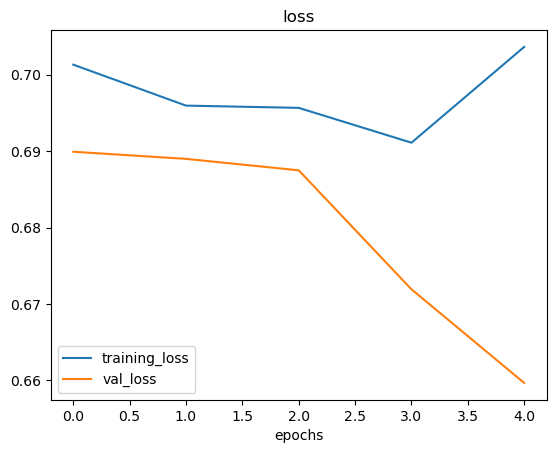

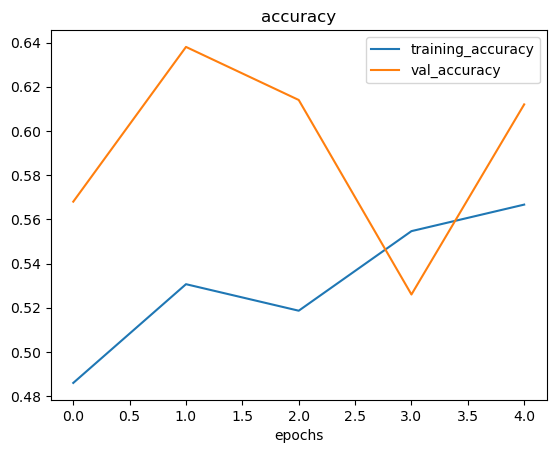

In [72]:
# Check our models training curves
plot_loss_curves(history=history_6)

Video N°126: Breaking our CNN model down part 12: Discovering the power of shuffling data

Let's shuffle our augmented training data and train another model (the same as before) on it and see what happens. 

In [73]:
common_args = {
    "target_size": (224, 224),
    "batch_size": 32,
    "class_mode": "binary",
    "shuffle": True
}

In [74]:
# import data and augment it and shuffle from training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir, **common_args)

Found 1500 images belonging to 2 classes.


In [76]:
conv2d_args = {
    "filters":10,
    "kernel_size":3,
    "activation": "relu"
}

In [77]:
# Create a model (same as model_5)
model_7 = Sequential([
    Conv2D(**conv2d_args),
    MaxPool2D(pool_size=2),
    Conv2D(**conv2d_args),
    MaxPool2D(),
    Conv2D(**conv2d_args),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled, # fitting model_6 on augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 17s 346ms/step - loss: 0.6771 - accuracy: 0.5813 - val_loss: 0.5738 - val_accuracy: 0.7680
Epoch 2/5
47/47 [==============================] - 16s 347ms/step - loss: 0.5671 - accuracy: 0.7267 - val_loss: 0.5298 - val_accuracy: 0.7100
Epoch 3/5
47/47 [==============================] - 17s 361ms/step - loss: 0.5497 - accuracy: 0.7393 - val_loss: 0.4082 - val_accuracy: 0.8260
Epoch 4/5
47/47 [==============================] - 16s 350ms/step - loss: 0.5029 - accuracy: 0.7480 - val_loss: 0.3774 - val_accuracy: 0.8420
Epoch 5/5
47/47 [==============================] - 16s 336ms/step - loss: 0.4942 - accuracy: 0.7713 - val_loss: 0.4218 - val_accuracy: 0.8220


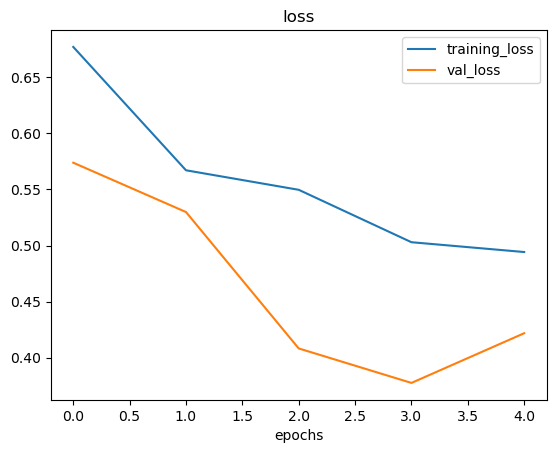

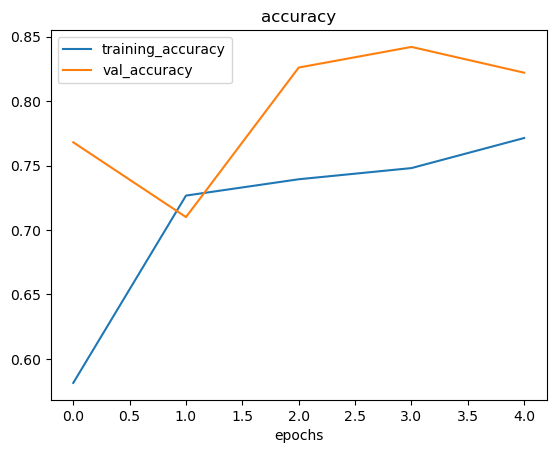

In [78]:
# Check our models training curves
plot_loss_curves(history=history_7)

🔑 **Note:** When shuffling data, the model gets exposed to all different kinds of data during training, thus enabling it to learn features across a wide array of images (in our case, pizza & steak at the same time instead of just pizza then steak).

Video N°127: Breaking our CNN model down part 13: Exploring options to improve our model

### 7. Repeat until satisied

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more `Conv2D` / `MaxPool2D` layers)
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32 even 64)
* Train for longer (more epochs)
* Find an ideal learning rate
* Get more data (give the model more opportunities to learn)
* Use **transfer learning** to leverage what another image model has learn and adjust it for our own use case

> 🛠 **Practice:** Recreate the model on the CNN explainer website (same as `model_1`) and see how it performs on the augmented shuffled training data.

Video N°128: Downloading a custom image to make predictions on

## Making a prediction with our trained model on our own custom data

In [79]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


In [98]:
url = "https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true"
filename= "03-steak.jpeg"
download_data(url=url, filename=filename, extract=False)

--2024-03-17 21:57:37--  https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/images/03-steak.jpeg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-steak.jpeg [following]
--2024-03-17 21:57:37--  https://github.com/mrdbourke/tensorflow-deep-learning/raw/main/images/03-steak.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg [following]
--2024-03-17 21:57:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com 

03-steak.jpeg has been downloaded.


... 38%  640K 0s
   750K .......... .......... .......... .......... .......... 41%  103M 0s
   800K .......... .......... .......... .......... .......... 43%  110M 0s
   850K .......... .......... .......... .......... .......... 46%  117M 0s
   900K .......... .......... .......... .......... .......... 49% 99.2M 0s
   950K .......... .......... .......... .......... .......... 51%  116M 0s
  1000K .......... .......... .......... .......... .......... 54%  117M 0s
  1050K .......... .......... .......... .......... .......... 56% 95.5M 0s
  1100K .......... .......... .......... .......... .......... 59% 97.6M 0s
  1150K .......... .......... .......... .......... .......... 62% 67.3M 0s
  1200K .......... .......... .......... .......... .......... 64% 82.2M 0s
  1250K .......... .......... .......... .......... .......... 67%  106M 0s
  1300K .......... .......... .......... .......... .......... 69%  106M 0s
  1350K .......... .......... .......... .......... .......... 72%  115

In [99]:
steak = mpimg.imread(filename)